# Algorytm PAM (Partitioning Around Medoids)

Input:

* dane w N wymiarach (zbiór punktów)
* metrykę dystansu (tutaj zakładamy odległość euklidesową)

Output:

* Znalezione skupienia punktów które są bliskie sobie
* Liczba skupień (k) jest wybranym przez użytkownika parametrem

#### Przykład klasteryzacji:


![Grupowanie](clustering.png "Title")

Algorytm PAM jest bardzo podobny do popularnego k-means

*Główna różnica jest taka że środkiem znalezionego skupienia jest jeden z punktów z danych wejściowych, a w k-means zwykle tak nie jest*

Pod względem wydajnościowym PAM jest zwykle wolniejszy niż k-means ale bardziej odporny na obserwacje odstające (dzięki temu że środek grupy musi być jednym z punktów).

### Algorytm

1. Wybranie losowo *k* punktów jako pierwszych medoid
2. Przypisanie każdego z punktów w danych do najbliższej medoidy
3. Tak długo jak następują zmiany / poprawa dystansów:
    1. Dla każdej z medoid podmieniamy ją z nie-medoidami i patrzymy, czy nastąpiała poprawa dystansów
    2. Jeśli tak, to wykonujemy podmianę i zapamiętujemy obecną wartość średniego dystansu

## Implementacja PAM (bez numpy)

In [46]:
from __future__ import annotations
from typing import Sequence

# Własna implementacja wielowymiarowych punktów
class Point:
    def __init__(self, coordinates : Sequence[float]):
        self.coordinates = coordinates
    def __str__(self):
        return str(['{:.2f}'.format(x) for x in self.coordinates])
    def __repr__(self):
        return self.__str__()
    def distance_to(self, other : Point) -> float: # Dystans euklidesowy
        if len(self.coordinates)!=len(other.coordinates): # Punkty muszą mieć te same wymiary
            raise ValueError
        dist = 0
        for x, y in zip(self.coordinates, other.coordinates):
            dist+=(x-y)**2
        dist = dist**(1/2)
        return dist

In [47]:
point_1 = Point([3,3,3])
point_2 = Point([1,1,1])

print(point_1.distance_to(point_2))

3.4641016151377544


In [48]:
print(point_1)

['3.00', '3.00', '3.00']


### Funkcje pomocnicze do generowania wielowymiarowych danych dookoła punktów

Dystans względem każdego z wymiarów

In [49]:
import random

def generate_data(centers : Sequence[Point], data_points : int, x_y_dist_from_center : float) -> Sequence[Point]: # Dystans manhattański
    points = []
    for x in range(data_points):
        center = random.choice(centers)
        coords = []
        for index in range(len(center.coordinates)):
            existing_coord = center.coordinates[index]
            coords.append(existing_coord+random.uniform(-x_y_dist_from_center,x_y_dist_from_center))
        points.append(Point(coords))
    return points

Losowe punkty w odległości euklidesowej od punktu

1. Wybór punktu (centrum)
2. Losowanie wektora kierunku + normalizacja
3. Mnożenie wektora kierunku przez losową odległość z zakresu (-dystans, dystans)
4. Dodanie tego wektora do centrum

In [50]:
def generate_data_sphere(centers : Sequence[Point], data_points : int, dist_from_center : float) -> Sequence[Point]: # Dystans euklidesowy (losowy wektor kierunku * losowy dystans)
    points = []
    for x in range(data_points):
        center = random.choice(centers)
        direction_vector = []
        for i in range(len(center.coordinates)):
            direction_vector.append(random.uniform(-1,1))
        direction_vector_length = 0
        for i in range(len(direction_vector)):
            direction_vector_length+=direction_vector[i]**2
        direction_vector_length = direction_vector_length**(1/2)
        direction_vector_normalized = [z/direction_vector_length for z in direction_vector]
        random_length = random.uniform(-dist_from_center, dist_from_center)
        coords_1 = [i*random_length for i in direction_vector_normalized]#direction_vector_normalized*random_length
        coords_2 = [x+y for x,y in zip(center.coordinates, coords_1)]
        points.append(Point(coords_2))
    return points

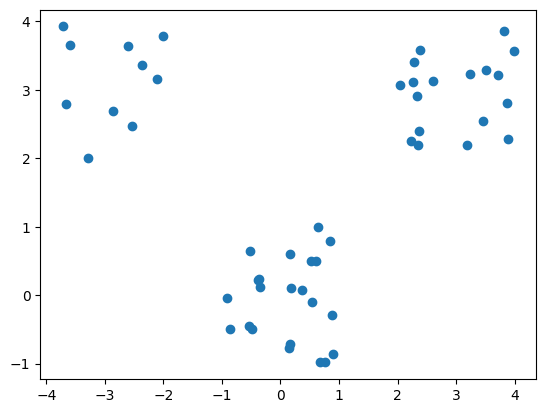

In [51]:
import matplotlib.pyplot as plt

def draw_custom_points(point_list : Sequence[Point]): #2D
    x_values = [point.coordinates[0] for point in point_list]
    y_values = [point.coordinates[1] for point in point_list]
    plt.scatter(x_values, y_values)
    plt.show()

generated_points = generate_data([Point([-3,3]), Point([3,3]), Point([0,0])],data_points=50, x_y_dist_from_center=1)

draw_custom_points(generated_points)

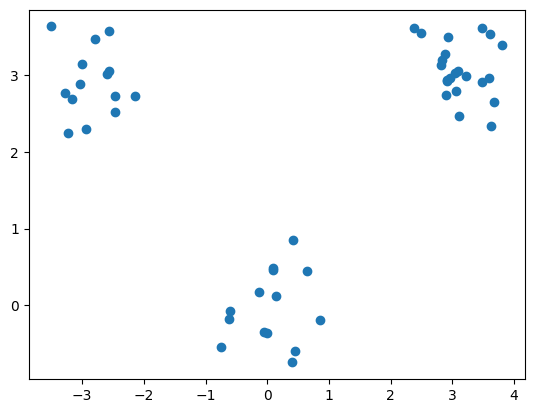

In [52]:
generated_points_sphere = generate_data_sphere([Point([-3,3]), Point([3,3]), Point([0,0])],data_points=50, dist_from_center=1)

draw_custom_points(generated_points_sphere)

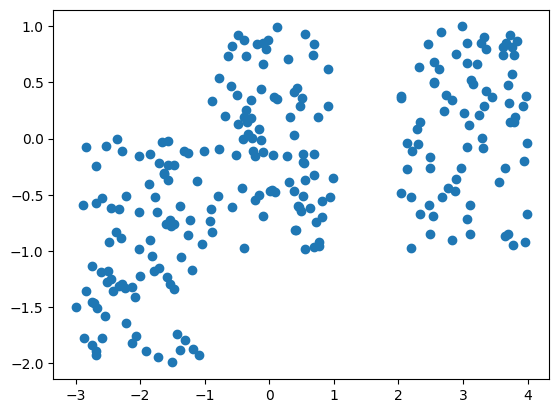

In [53]:
generated_points = generate_data([Point([-2,-1]), Point([0,0]), Point([3,0])],data_points=250, x_y_dist_from_center=1)

draw_custom_points(generated_points)

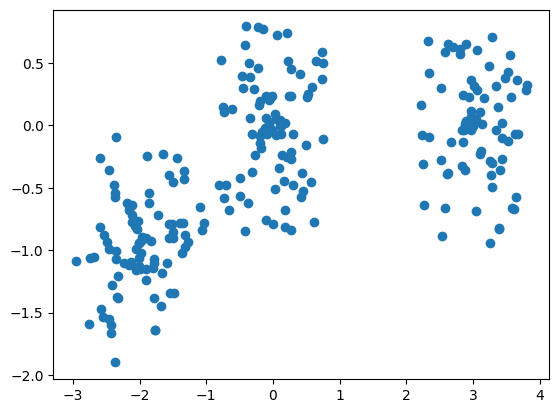

In [54]:
generated_points = generate_data_sphere([Point([-2,-1]), Point([0,0]), Point([3,0])],data_points=250, dist_from_center=1)

draw_custom_points(generated_points)

### Funkcja do wizualizacji grup

In [55]:
def draw_clustering(assignment): # Pojedynczy obraz
    for medoid in assignment.keys():
        point_list = assignment[medoid]
        x_values = [point.coordinates[0] for point in point_list]
        y_values = [point.coordinates[1] for point in point_list]
        plt.scatter(x_values, y_values, alpha=0.5)
    x_values = [point.coordinates[0] for point in assignment.keys()]
    y_values = [point.coordinates[1] for point in assignment.keys()]
    plt.scatter(x_values, y_values,color='r', marker='*')
    plt.show()

### Implementacja PAM

In [56]:
def medoid_similarity(medoid : Point, other_points : Sequence[Point]) -> float: # Suma dystansów punktów od danej medoidy
    distances = 0
    for point in other_points:
        distances+= medoid.distance_to(point)
    return distances

def assign_points_to_medoids(medoids : Sequence [Point], points : Sequence [Point]) -> dict():
    assignments = dict()
    for i in medoids:
        assignments[i] = []
    for point in points:
        minimum_distance = point.distance_to(medoids[0])
        selected_medoid = medoids[0]
        for med in medoids[1:]:
            new_distance = point.distance_to(med)
            if new_distance<minimum_distance:
                minimum_distance = new_distance
                selected_medoid = med
        assignments[selected_medoid].append(point)
    return assignments

def evaluate_assignment(assignment): # Suma dystansów wszystkich punktów od swoich medoid
    sum_of_distances = 0
    for i in assignment.keys():
            sum_of_distances+=medoid_similarity(i,assignment[i])
    return sum_of_distances

def pam_clustering(points : Sequence[Point], k : int):
    # Inicjalizacja
    if k<2 or len(points)<k:
        raise ValueError
    medoids = random.sample(points, k)
    assignments = assign_points_to_medoids(medoids, points)

    # Aktualizacja
    finished = False
    counter = 1
    while not finished:
        print(f"Iteracja #{counter}")
        counter+=1
        finished = True # Zmienione jeśli zmieni się którakolwiek medoida
        old_medoids = list(assignments.keys())
        sum_of_distances = evaluate_assignment(assignments)
        print(f"Suma dystansów: {sum_of_distances}")
        for med in old_medoids:
            for p in points:
                if p in old_medoids:
                    continue # Punkt już był medoidą więc go nie podmieniamy
                temp_medoids = list(old_medoids)
                temp_medoids.remove(med)
                temp_medoids.append(p)
                temp_assignment = assign_points_to_medoids(temp_medoids, points)
                new_distance = evaluate_assignment(temp_assignment)
                if new_distance<sum_of_distances:
                    finished = False
                    assignments = temp_assignment
    return assignments

In [57]:
assigned = pam_clustering(generated_points, 3)

Iteracja #1
Suma dystansów: 434.617796455687
Iteracja #2
Suma dystansów: 264.08951904585876
Iteracja #3
Suma dystansów: 261.2793052260453
Iteracja #4
Suma dystansów: 260.85114450030653
Iteracja #5
Suma dystansów: 260.6058082820335
Iteracja #6
Suma dystansów: 260.4464699552831
Iteracja #7
Suma dystansów: 260.10321768609066
Iteracja #8
Suma dystansów: 196.62056427902047
Iteracja #9
Suma dystansów: 182.11973310593467
Iteracja #10
Suma dystansów: 165.26633815194202
Iteracja #11
Suma dystansów: 164.96801655579426
Iteracja #12
Suma dystansów: 164.76351795007898
Iteracja #13
Suma dystansów: 164.7398575438859
Iteracja #14
Suma dystansów: 127.60705219305643
Iteracja #15
Suma dystansów: 126.90465381027721
Iteracja #16
Suma dystansów: 125.85723677651899
Iteracja #17
Suma dystansów: 125.72984134429592


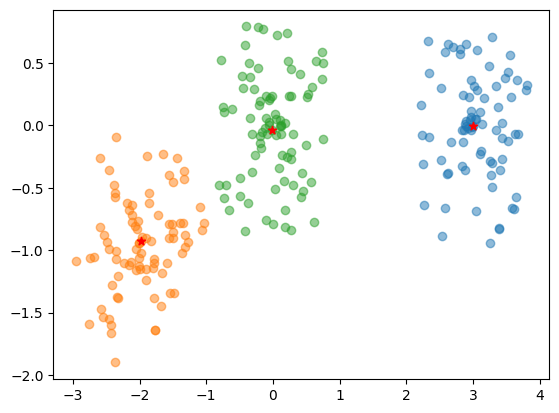

In [58]:
draw_clustering(assigned)

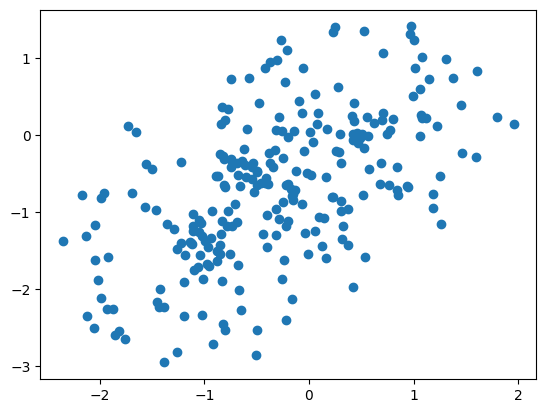

In [59]:
generated_points = generate_data_sphere([Point([-1,-1.5]), Point([-0.5,-0.5]), Point([0.5,0])],data_points=250, dist_from_center=1.5)

draw_custom_points(generated_points)

In [60]:
assigned = pam_clustering(generated_points, 3)

Iteracja #1
Suma dystansów: 243.98967622114225
Iteracja #2
Suma dystansów: 222.0364217881434
Iteracja #3
Suma dystansów: 216.99784343452706
Iteracja #4
Suma dystansów: 208.83179723203483
Iteracja #5
Suma dystansów: 189.60895077892857
Iteracja #6
Suma dystansów: 188.71433884981388
Iteracja #7
Suma dystansów: 180.490761866527
Iteracja #8
Suma dystansów: 180.19838386092528
Iteracja #9
Suma dystansów: 179.8660553672085
Iteracja #10
Suma dystansów: 179.8536292324992
Iteracja #11
Suma dystansów: 178.97570181315245
Iteracja #12
Suma dystansów: 178.89244011436267
Iteracja #13
Suma dystansów: 178.34753499716496
Iteracja #14
Suma dystansów: 178.19596929138834
Iteracja #15
Suma dystansów: 165.77720257659146
Iteracja #16
Suma dystansów: 164.18186436174895
Iteracja #17
Suma dystansów: 164.0636488364166
Iteracja #18
Suma dystansów: 163.10129112522043
Iteracja #19
Suma dystansów: 162.98527642121257
Iteracja #20
Suma dystansów: 162.30806701011045
Iteracja #21
Suma dystansów: 162.18265851612782
Iteracj

Dużo iteracji jest "zmarnowane" na bardzo drobne poprawy dystansu

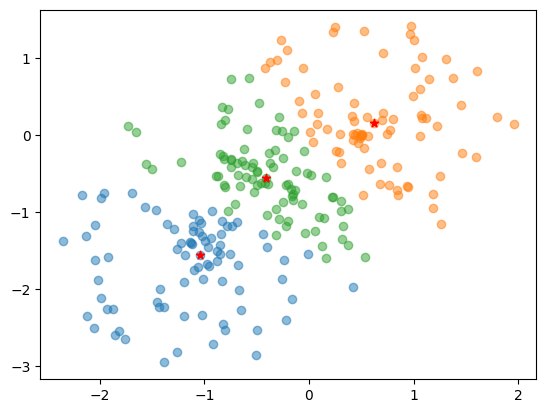

In [61]:
draw_clustering(assigned)

In [63]:
import pprint
pprint.pprint(assigned)

{['-0.41', '-0.55']: [['-0.74', '-0.32'],
                      ['-0.62', '-0.18'],
                      ['-0.26', '0.06'],
                      ['-0.13', '-0.72'],
                      ['-0.53', '-0.36'],
                      ['0.22', '-0.80'],
                      ['-0.64', '-0.34'],
                      ['-0.20', '-1.12'],
                      ['0.38', '-1.42'],
                      ['-0.25', '-0.30'],
                      ['-0.33', '-0.19'],
                      ['-0.70', '-0.90'],
                      ['-1.50', '-0.44'],
                      ['-0.32', '-0.95'],
                      ['-0.17', '-0.70'],
                      ['0.30', '-0.99'],
                      ['-0.42', '-0.62'],
                      ['-1.65', '0.04'],
                      ['-0.41', '-0.55'],
                      ['-0.54', '-0.41'],
                      ['-0.83', '0.36'],
                      ['-0.48', '0.41'],
                      ['0.31', '-0.86'],
                      ['-0.74', '-0.32'],


### Test na zbiorze danych Iris

In [64]:
import pandas as pd

df = pd.read_csv("Iris.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


### W celu łatwiejszej wizualizacji bierzemy pod uwagę tylko dwie zmienne

Iteracja #1
Suma dystansów: 208.75650656990624
Iteracja #2
Suma dystansów: 205.49853399261397
Iteracja #3
Suma dystansów: 204.25697334421366
Iteracja #4
Suma dystansów: 200.61634101769542
Iteracja #5
Suma dystansów: 199.7822154497639
Iteracja #6
Suma dystansów: 197.1753293339581
Iteracja #7
Suma dystansów: 141.19412116737692
Iteracja #8
Suma dystansów: 83.09469686229966
Iteracja #9
Suma dystansów: 83.03438870792166
Iteracja #10
Suma dystansów: 82.64480640416339
Iteracja #11
Suma dystansów: 79.97152485282157
Iteracja #12
Suma dystansów: 78.83128830941482
Iteracja #13
Suma dystansów: 77.28460137329213
Iteracja #14
Suma dystansów: 76.44054418397423
Iteracja #15
Suma dystansów: 75.68752087906972
Iteracja #16
Suma dystansów: 75.60046263155463


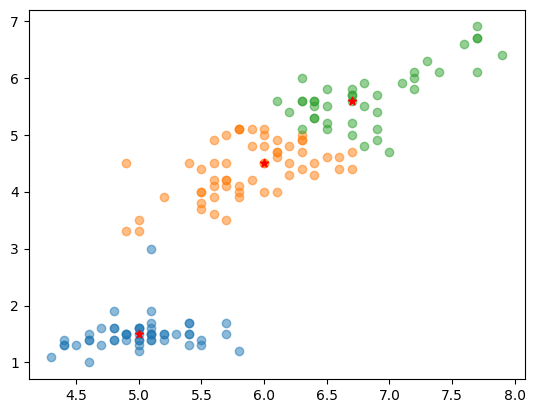

In [65]:
sepal_length = df["SepalLengthCm"].tolist()
petal_length = df["PetalLengthCm"].tolist()

data_points = [Point([x,y]) for (x,y) in list(zip(sepal_length,petal_length))]
iris_assignments = pam_clustering(data_points, 3)
draw_clustering(iris_assignments)

Prawdziwe klasy dla porównania (pierwsza kolumna, trzeci rząd):

<br/>

<div>
<img src="Iris_dataset_scatterplot.jpg" width="1024"/>
</div>




Źródło: Nicoguaro, CC BY 4.0 <https://creativecommons.org/licenses/by/4.0>, via Wikimedia Commons